In [0]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Import Libraries

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D, AveragePooling2D
from keras.utils import plot_model
import scipy.ndimage
import os

CURR_DIR = "/content/drive/My Drive/input_analysis"

Using TensorFlow backend.


# Import MNIST

In [0]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


# Reshape the input

In [0]:
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],x_train.shape[2],1))
print(x_train.shape)
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],x_test.shape[2],1))
print(x_test.shape)
x_train = x_train/255
x_test  = x_test/255
x_train = x_train.astype('float')
x_test  = x_test.astype('float')

(60000, 28, 28, 1)
(10000, 28, 28, 1)


#Increase size of images from 28x28 to 32x32


In [0]:
x_train = np.pad(x_train, ((0,0),(2,2),(2,2), (0,0)), 'constant')
x_test = np.pad(x_test, ((0,0),(2,2),(2,2), (0,0)), 'constant')

print("Updated Image Shape: {}".format(x_train.shape))

Updated Image Shape: (60000, 32, 32, 1)


# Implement LeNet

In [0]:
model = Sequential()

model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
model.add(AveragePooling2D())

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))

#model.add(GlobalAveragePooling2D())
# uncomment below and comment above line for actual model
#"""
model.add(AveragePooling2D())

model.add(Flatten())

model.add(Dense(units=120, activation='relu'))

model.add(Dense(units=84, activation='relu'))
#"""

model.add(Dense(units=10, activation = 'softmax'))

#Fit Model

In [0]:
model.summary()
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model.fit(x_train,y_train,batch_size=32,epochs=5,validation_split=0.1,shuffle=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d_1 (Average (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_2 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               69240     
_________________________________________________________________
dense_2 (Dense)              (None, 84)               

#Run model on test data

In [0]:
score = model.evaluate(x_test, y_test, verbose=False) 
model.metrics_names
print('Test score: ', score[0])    #Loss on test
print('Test accuracy: ', score[1])
model.summary()

model.save(os.path.join(CURR_DIR, "lenet.h5"))

Test score:  0.05189018197883852
Test accuracy:  0.9831
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d_1 (Average (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_2 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               69240     
________________________________________________________________

## Context Activation Mapping

In [0]:
from keras.models import Model
import scipy as sp
#gap_weights = model.layers[-1].get_weights()[0]
#gap_weights.shape

Target Class = 2


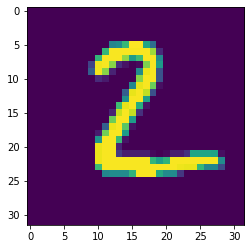

In [0]:
plt.imshow(np.squeeze(x_test[1],-1))

predict = model.predict((x_test[1])[np.newaxis,...])
#print(decode_predictions(predict,top=3))
target_class = np.argmax(predict[0])
print("Target Class = %d"%target_class)

Tensor("dense_3/Softmax:0", shape=(?, 10), dtype=float32)


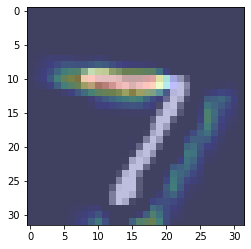

In [0]:
from keras import backend as K
from vis.utils import utils
import cv2

def grad_cam():
  print(model.output)
  class_output = model.output[:,7]
  #print(class_output)

  # layer output
  convolution_output = model.get_layer('conv2d_2').output

  # get gradients
  grads = K.gradients(class_output, convolution_output)[0]

  # get convolution output and gradients for input
  gradient_function = K.function([model.input], [convolution_output, grads])

  output, grads_val = gradient_function([(x_test[0])[np.newaxis,...]])
  output, grads_val = output[0], grads_val[0]
  
  weights = np.mean(grads_val, axis=tuple(range(grads_val.ndim-1)))
  
  cam = np.dot(output, weights)
  
  # create heat map
  x_scale = x_test.shape[1] / cam.shape[0]
  y_scale = x_test.shape[2] / cam.shape[1]
  cam = scipy.ndimage.zoom(cam, (x_scale,y_scale), order=1)

  cam = np.maximum(cam, 0)
  cam = cam / np.max(cam)

  plt.imshow(cam, cmap = 'jet', alpha = 0.5)
  plt.imshow(np.squeeze(x_test[0],-1), cmap = 'gray', alpha = 0.5)
  
grad_cam()